<a href="https://colab.research.google.com/github/rtegao/M5Forecasting/blob/master/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

# Importing Data Set

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/Specialization/Projects/Recurrent Neural Networks/M5 - Data/sales_train_validation.csv')

In [3]:
dataset.shape

(30490, 1919)

In [4]:
dataset.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [5]:
dataset.loc[:,'d_1':].shape

(30490, 1913)

# In this Notebook I'll try to crate 3 LSTM models. The first model for one hobbie product from California, the second for one household product from Texas and the third for one food product from Winsconsin.


In [6]:
dataset.groupby(['state_id','cat_id']).first()

id  ... d_1913
state_id cat_id                                      ...       
CA       FOODS          FOODS_1_001_CA_1_validation  ...      0
         HOBBIES      HOBBIES_1_001_CA_1_validation  ...      1
         HOUSEHOLD  HOUSEHOLD_1_001_CA_1_validation  ...      1
TX       FOODS          FOODS_1_001_TX_1_validation  ...      0
         HOBBIES      HOBBIES_1_001_TX_1_validation  ...      2
         HOUSEHOLD  HOUSEHOLD_1_001_TX_1_validation  ...      0
WI       FOODS          FOODS_1_001_WI_1_validation  ...      1
         HOBBIES      HOBBIES_1_001_WI_1_validation  ...      1
         HOUSEHOLD  HOUSEHOLD_1_001_WI_1_validation  ...      0

[9 rows x 1917 columns]

In [0]:
group = dataset.groupby(['state_id','cat_id']).first()

df_hobbie =  group.loc[('CA','HOBBIES'),'d_1':]
df_houseold =  group.loc[('TX','HOUSEHOLD'),'d_1':]
df_food =  group.loc[('WI','FOODS'),'d_1':]

del group

# Spliting Data

In [8]:
train_limit = int(round((df_hobbie.shape[0])*0.7,0))
val_limit = int(round((df_hobbie.shape[0])*0.85,0))

df_hobbie_train = df_hobbie[:train_limit]
df_hobbie_val = df_hobbie[train_limit:val_limit]
df_hobbie_test = df_hobbie[val_limit:]

df_houseold_train = df_houseold[:train_limit]
df_houseold_val = df_houseold[train_limit:val_limit]
df_houseold_test = df_houseold[val_limit:]

df_food_train = df_food[:train_limit]
df_food_val = df_food[train_limit:val_limit]
df_food_test = df_food[val_limit:]



print(df_hobbie_train.shape)
print(df_hobbie_val.shape)
print(df_hobbie_test.shape)

print('\n')
print(df_houseold_train.shape)
print(df_houseold_val.shape)
print(df_houseold_test.shape)

print('\n')
print(df_food_train.shape)
print(df_food_val.shape)
print(df_food_test.shape)

(1339,)
(287,)
(287,)


(1339,)
(287,)
(287,)


(1339,)
(287,)
(287,)


# Normalizing Data


In [9]:
df_hobbie_train = df_hobbie_train.values.reshape(-1,1)
df_hobbie_val = df_hobbie_val.values.reshape(-1,1)
df_hobbie_test = df_hobbie_test.values.reshape(-1,1)

df_houseold_train = df_houseold_train.values.reshape(-1,1)
df_houseold_val = df_houseold_val.values.reshape(-1,1)
df_houseold_test = df_houseold_test.values.reshape(-1,1)

df_food_train = df_food_train.values.reshape(-1,1)
df_food_val = df_food_val.values.reshape(-1,1)
df_food_test = df_food_test.values.reshape(-1,1)

print(df_hobbie_train.shape)
print(df_hobbie_val.shape)
print(df_hobbie_test.shape)

print('\n')
print(df_houseold_train.shape)
print(df_houseold_val.shape)
print(df_houseold_test.shape)

print('\n')
print(df_food_train.shape)
print(df_food_val.shape)
print(df_food_test.shape)

(1339, 1)
(287, 1)
(287, 1)


(1339, 1)
(287, 1)
(287, 1)


(1339, 1)
(287, 1)
(287, 1)


In [0]:
scaler = MinMaxScaler(feature_range=(0,1))

df_hobbie_train = scaler.fit_transform(df_hobbie_train)
df_hobbie_test = scaler.transform(df_hobbie_val)
df_hobbie_val = scaler.transform(df_hobbie_test)

df_houseold_train = scaler.fit_transform(df_houseold_train)
df_houseold_test = scaler.transform(df_houseold_val)
df_houseold_val = scaler.transform(df_houseold_test)

df_food_train = scaler.fit_transform(df_food_train)
df_food_test = scaler.transform(df_food_val)
df_food_val = scaler.transform(df_food_test)

# Regressor

- # The competition determines that the model predict 28 days in the future, so we need to scale the regressor and the outputs for this prerequisite.

- # The step time for each LTMS can be different, so lets start with the Hobbies data



In [0]:
future_steps = 28 # how many days in the furure to predict 
time_steps = 60 # number of samples the LSTM model will use for predict 28 days in the future
n_features = 1 # number of features (LSTM input) 

#################### TRAIN #################################################
# Defining the number of samples for the train data
n_samples = df_hobbie_train.shape[0]
x_train = []
y_train = []

# shaping data to have the number of time_steps in the x_train ans the 28 future values in the y_train 
for i in range(time_steps,n_samples - time_steps): 
  x_train.append(df_hobbie_train[i - time_steps : i, 0])
  y_train.append(df_hobbie_train[i : i+future_steps,0])

x_train,y_train = np.array(x_train),np.array(y_train) # transforming in array
# LSTM need 3D tensor as input 
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],n_features))  

##################### VALIDATION ###############################################

# to predict the first 28 values of the validation data, LSTM need time_steps values. 
# to make this possible I'm using the last 60 values that came before the validation data.
df_hobbie_val = np.concatenate((df_hobbie_train[-time_steps:],df_hobbie_val))

n_samples = df_hobbie_val.shape[0]
x_val = []
y_val = []

for i in range(time_steps,n_samples - time_steps):
  x_val.append(df_hobbie_val[i - time_steps : i, 0])
  y_val.append(df_hobbie_val[i : i+future_steps,0])

x_val,y_val = np.array(x_val),np.array(y_val)
x_val = np.reshape(x_val,(x_val.shape[0],x_val.shape[1],n_features))

####################### TEST ################################################
# the same methodologie implemented in training and validation data are here in the test data

df_hobbie_test = np.concatenate((df_hobbie_val[-time_steps:],df_hobbie_test))
n_samples = df_hobbie_test.shape[0]
x_test = []
y_test = []

for i in range(time_steps,n_samples - time_steps):
  x_test.append(df_hobbie_test[i - time_steps : i, 0])
  y_test.append(df_hobbie_test[i : i+future_steps,0])

x_test,y_test = np.array(x_test),np.array(y_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],n_features))

# LSTM 

## First try

In [0]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, n_features))) # return_sequences=False next layer is not LSTM
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 100, batch_size=32, verbose = 0)

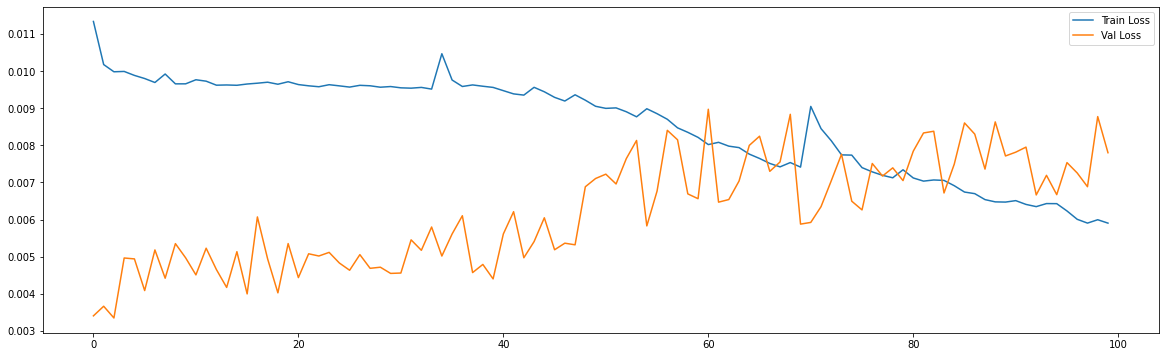

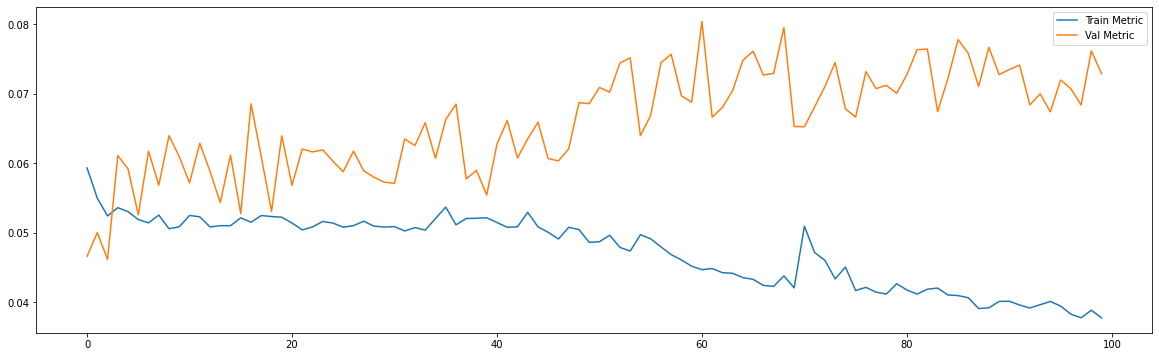

In [14]:
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

## Adding one hidden layer

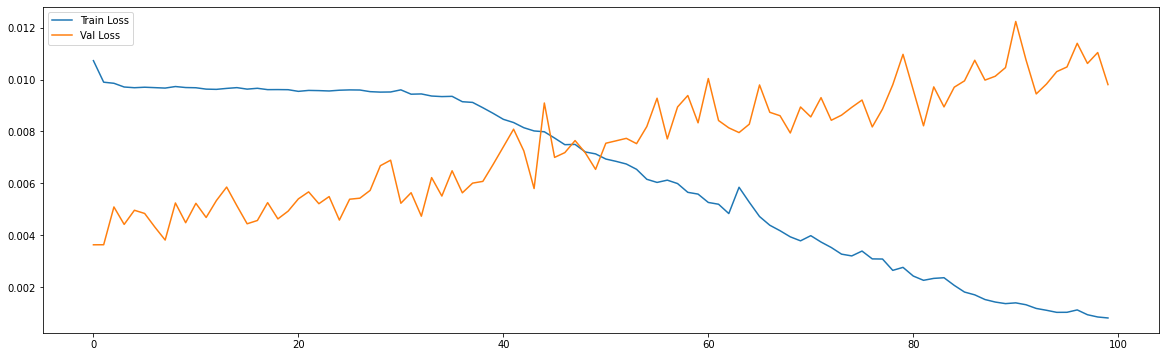

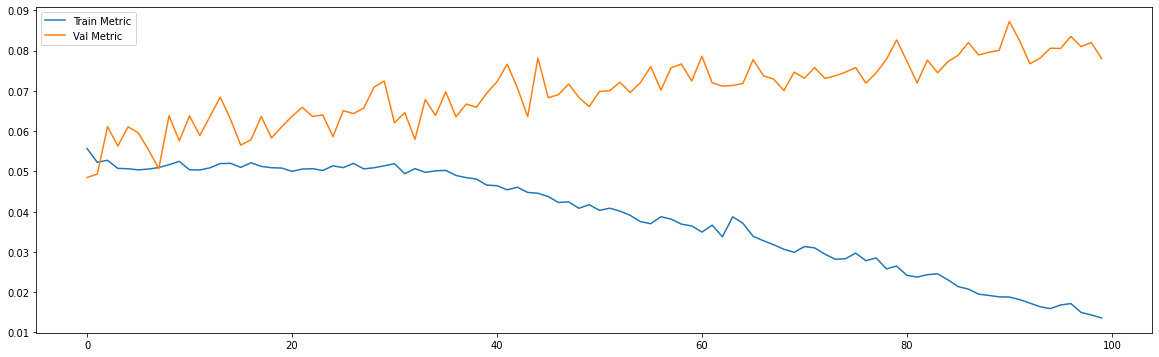

In [15]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(LSTM(units=50))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 100, batch_size=32, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

## Dropout at the first layer

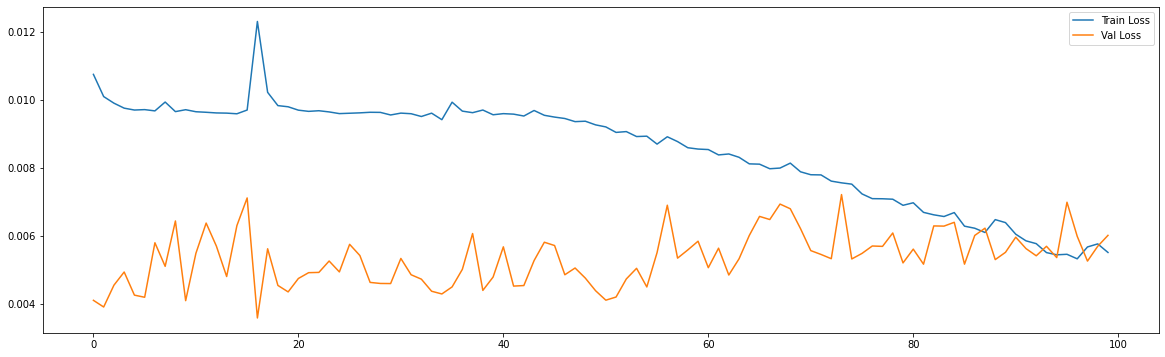

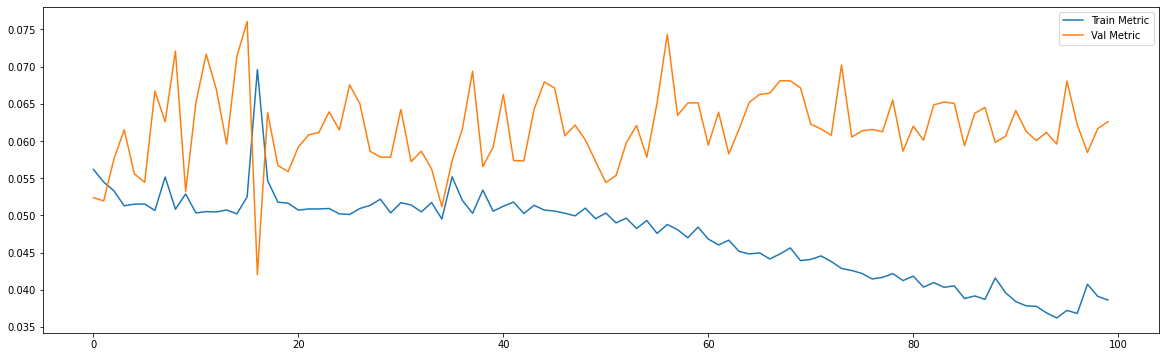

In [16]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(LSTM(units=50))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 100, batch_size=32, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

## Dropout at the first and second layers

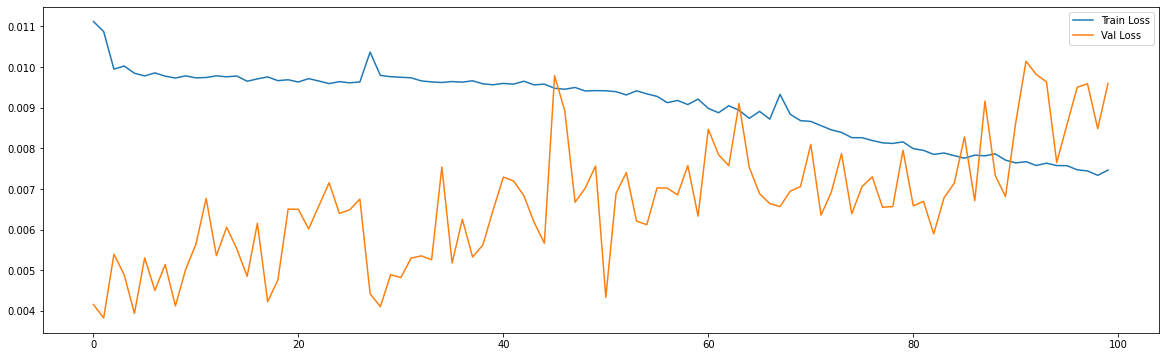

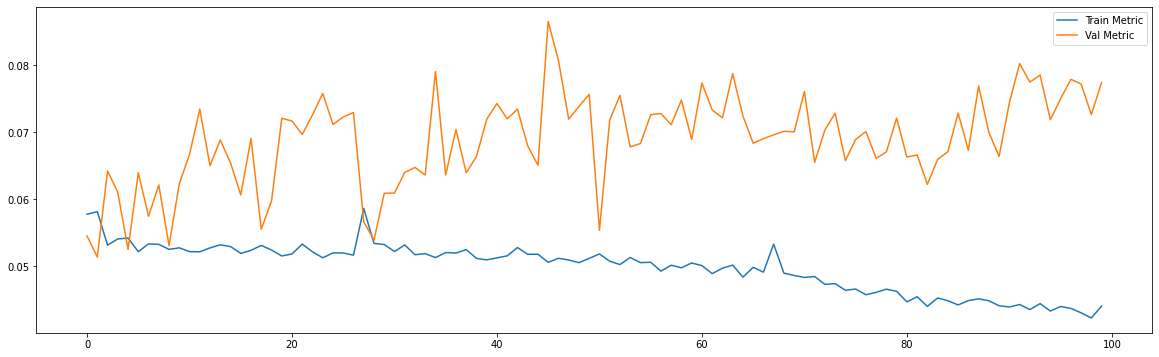

In [17]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.25))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 100, batch_size=32, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

## Decreasing the learning rate from 0.01 to 0.001

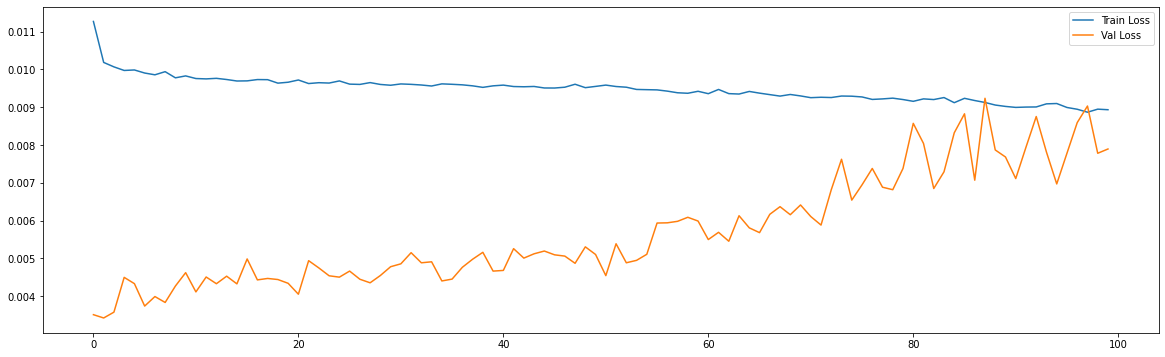

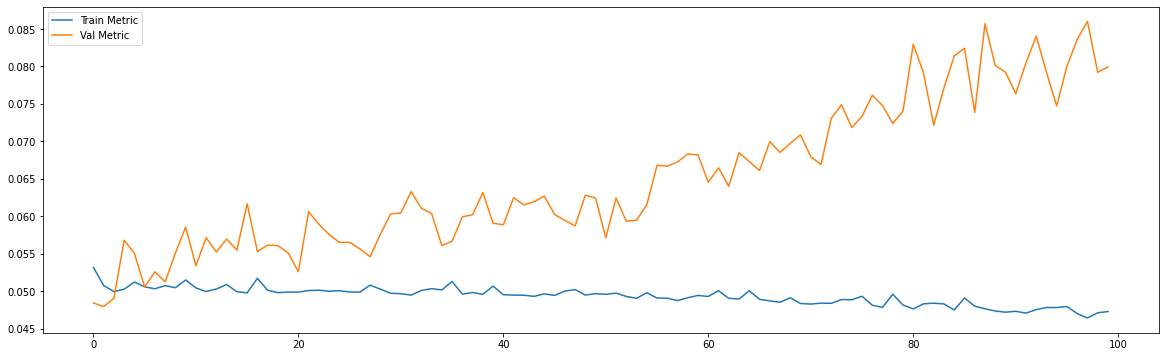

In [18]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.25))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 100, batch_size=32, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

## Adding more 30 neurons at the layers

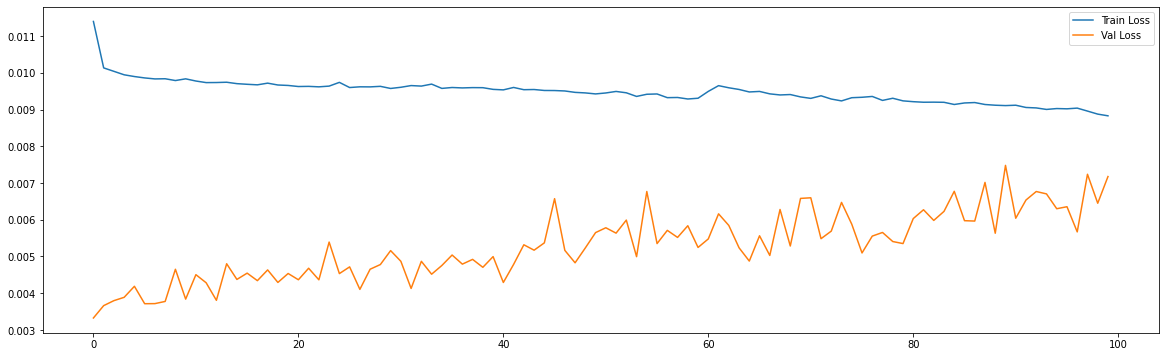

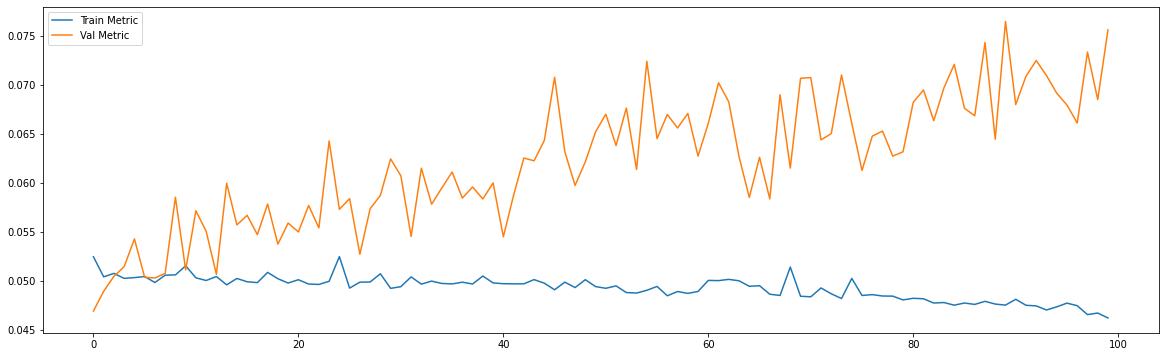

In [19]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=70, return_sequences=True, input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(LSTM(units=70))
regressor.add(Dropout(0.25))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 100, batch_size=32, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

## Going back to 50 neurons and adding one more hidden layer 

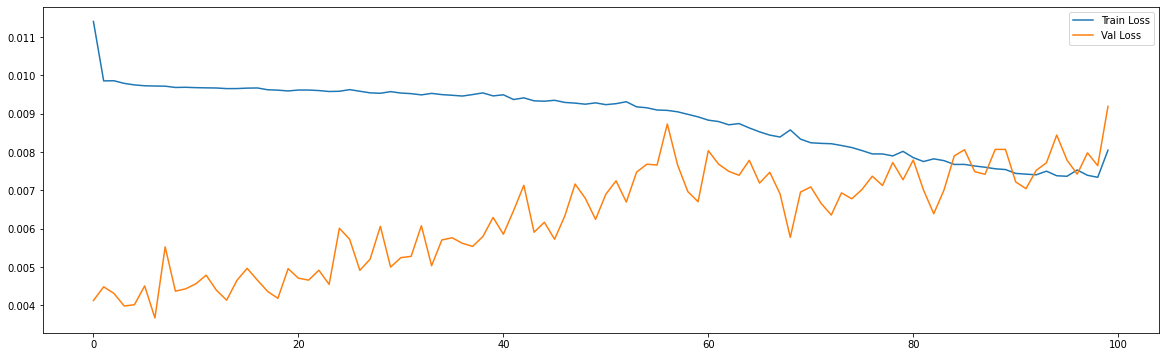

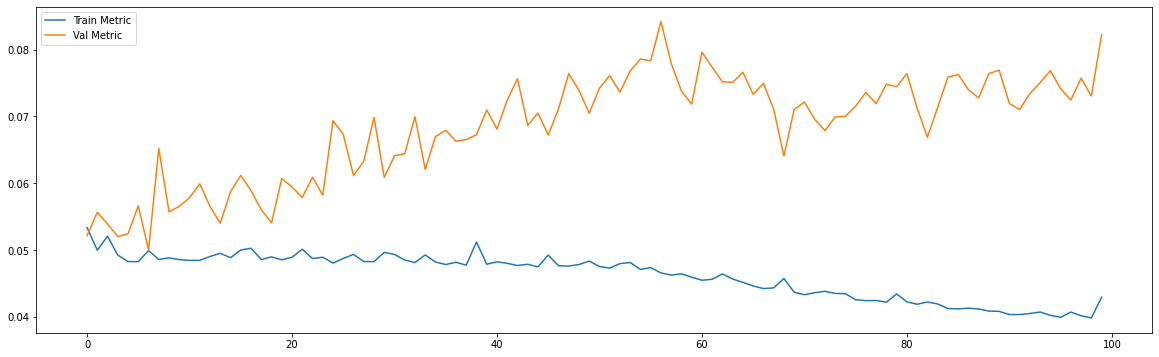

In [20]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(LSTM(units=50,return_sequences=True)) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(LSTM(units=50))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 100, batch_size=32, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

## Drop out at all hidden layers

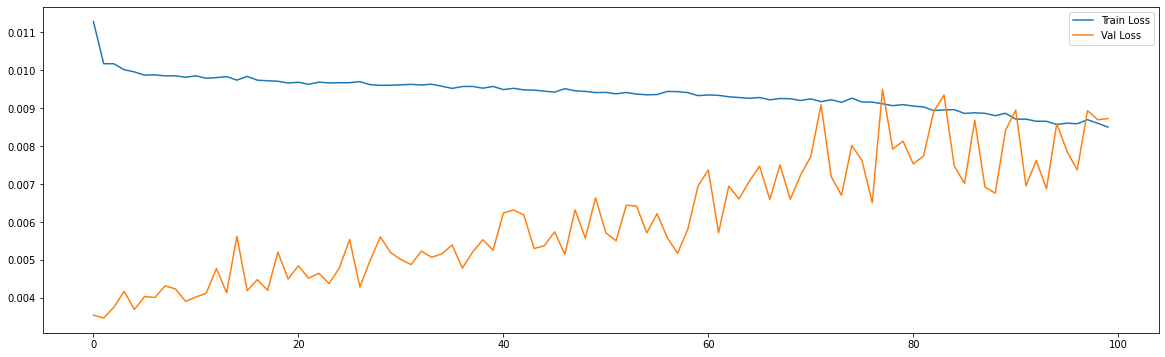

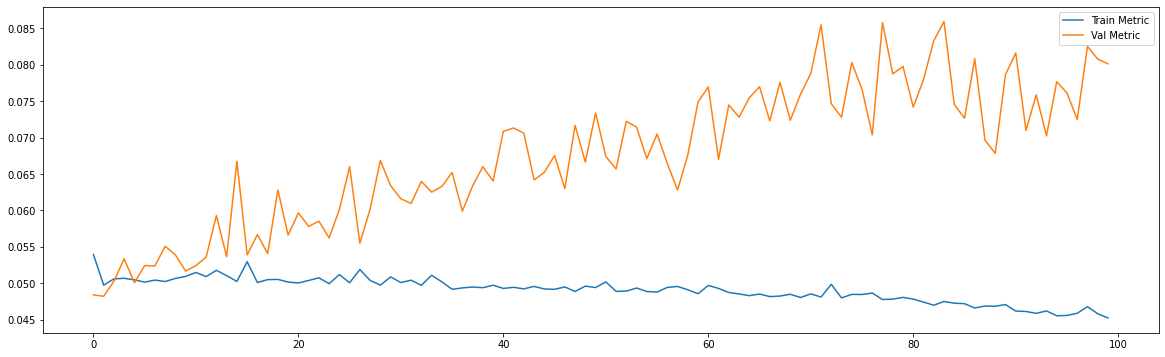

In [21]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(LSTM(units=50,return_sequences=True)) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.25))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 100, batch_size=32, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

## Decreasing the learning rate from 0.001 to 0.0001

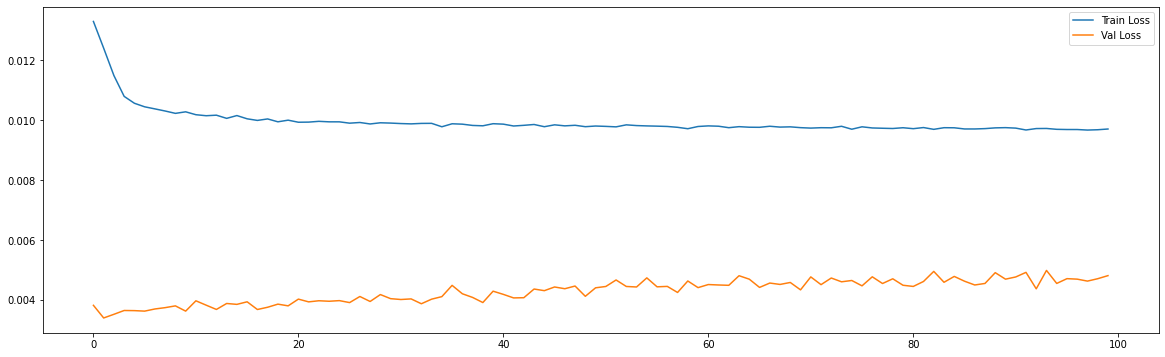

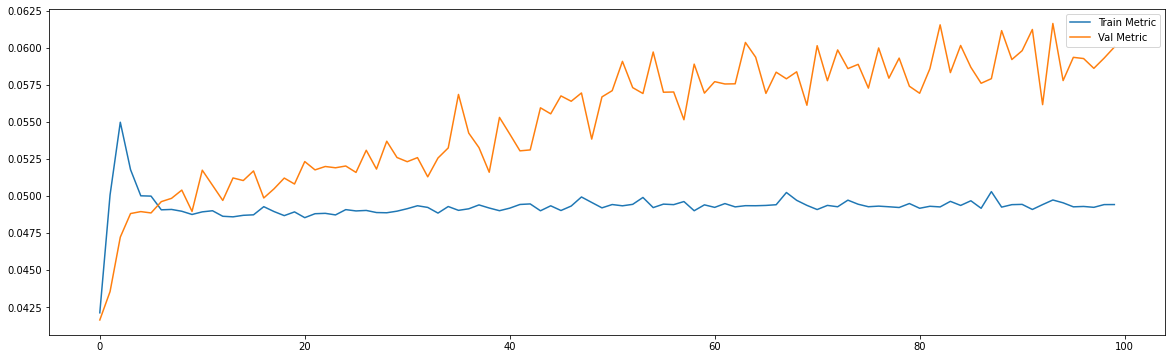

In [22]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(LSTM(units=50,return_sequences=True)) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.25))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 100, batch_size=32, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

## 1000 epochs

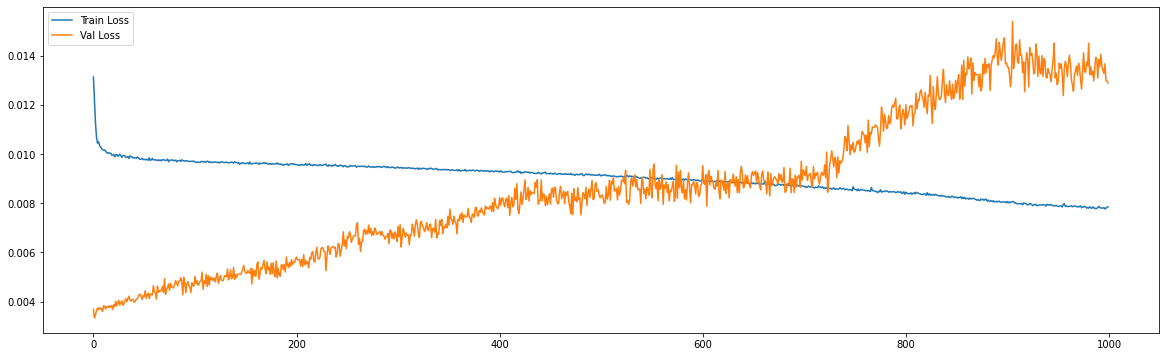

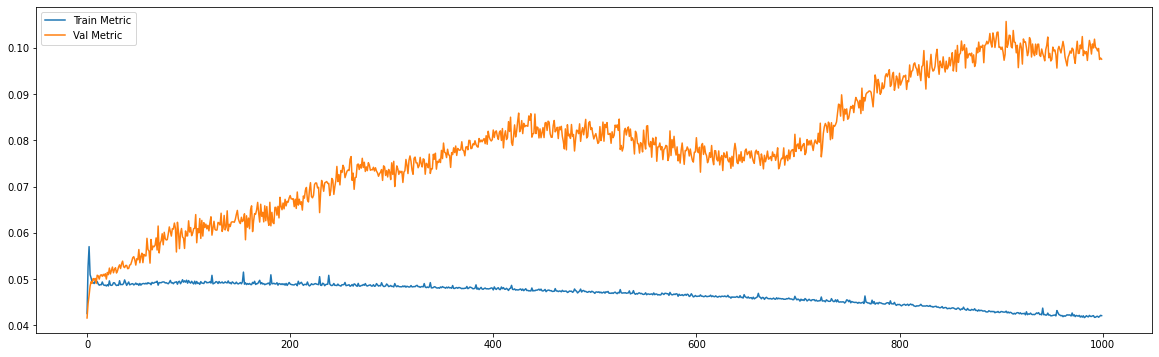

In [23]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(LSTM(units=50,return_sequences=True)) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.25))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 1000, batch_size=32, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

## L2 regularization

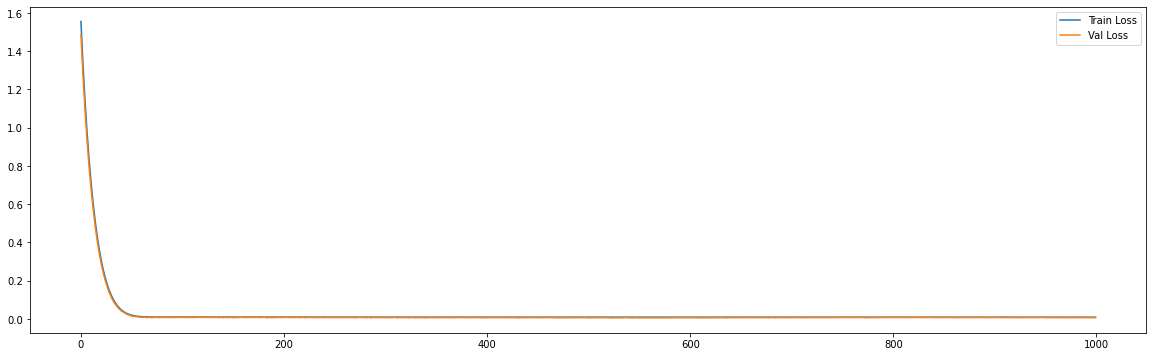

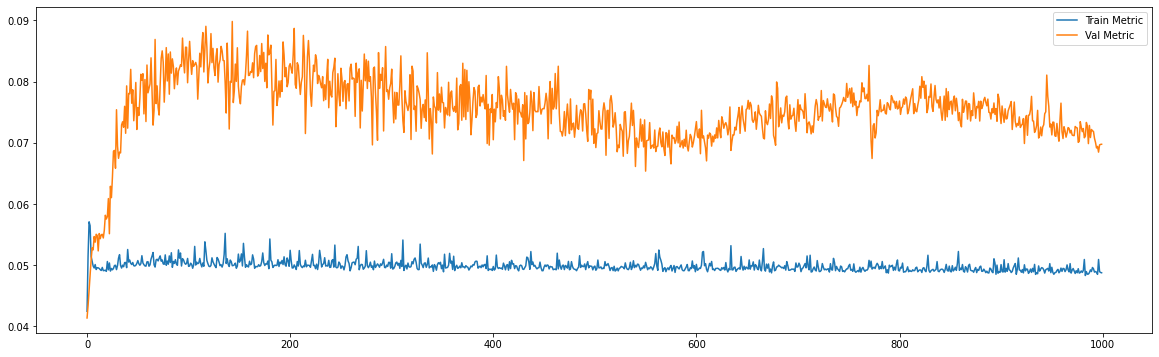

In [24]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(LSTM(units=50,return_sequences=True, kernel_regularizer = regularizers.l2(0.01))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(LSTM(units=50, kernel_regularizer = regularizers.l2(0.01)))
regressor.add(Dropout(0.25))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 1000, batch_size=32, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

# Predictin Data

In [0]:
y_predict_train = regressor.predict(x_train)
y_predict_val = regressor.predict(x_val)
y_predict_test = regressor.predict(x_test)